### OMP vs F-G-OLS
We have discussed that there are two methods, Orthogonal Matching Pursuit and Forward-Greedy-Ordinary Least Squares. 

Let us first assume the one-dimensional example. Assume that we have data $\mathbf{X} \in \mathbb{R}^{T \times p}$, and we have a signal defined as $$Y = X w,$$ where $Y \in \mathbb{R}^T$, and $w \in \mathbb{R}^p$.

Assume we already have a set of $k$ atoms, $\Gamma^k$. Then, the current residual is $$r_k = X_{\Gamma^k} w_{\Gamma^k} - Y.$$ Both methods iteratively add the next "best" possible atom. They only differ in their definition of "best". 
- For OMP, we pick the atom that is most correlated with the residual. In mathematical notation:

$$i_{k+1} = \underset{i}{\arg \max} |\tilde{x_i} X_{\Gamma^k \cup i} r_k|$$

- For F-G-OLS, we pick the atom that minimizes the residual error. In mathematical notation:

$$i = \underset{i}{\arg \min} ||Y - X_{\Gamma^k \cup i} X_{\Gamma^k \cup i}^\dagger Y||_2$$

Both methods have the exact same goal, find a subset $\Gamma^k$ and an accompanying coefficient vector $\tilde{w}$ such that $X_{\Gamma^k}w$ approximates $Y$ well, thereby minimizing the residual error. However, their criteria slightly differ.

The question is: when do the methods yield a different choice?

From [this paper](https://eprints.soton.ac.uk/142469/1/BDOMPvsOLS07.pdf) we see that they are not the same, and give a geographical interpretation. For this, we consider a three-dimensional example.

In [1]:
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit

import sys
sys.path.append("..")
import helper.helper as h

### Generate Data

In [2]:
## Number of samples, number of variables
T, p = 20, 10

## Generate random X
X = np.random.rand(T, p)

# for i in range(p):
#     X[:, i] = normalize(X[:, i])

## Generate true coefficient vector w
w = range(p) + np.ones(p)

## Compute Y
Y = X @ w

### OMP Implementation of $\texttt{sklearn}$.

In [3]:
omp = OrthogonalMatchingPursuit(n_nonzero_coefs = 1, normalize = True, fit_intercept = False)
omp_fit = omp.fit(X, Y)
print(np.round(omp_fit.coef_, 2))

[ 0.    0.    0.    0.    0.    0.   39.18  0.    0.    0.  ]


### One step of Orthogonal Matching Pursuit

In [248]:
def normalize(x): return x / np.linalg.norm(x)

def OMP_GAINS(X, Y, w):
    r = Y - X @ w
    return [np.abs(np.dot(normalize(x), r)) for x in X.T]

def OLS(X, Y, F):
    F_copy = F.copy()
    F_copy.sort()
    w = np.zeros(p)
    w[F_copy] = np.linalg.pinv(X[:, F_copy]) @ Y
    
    return w

In [8]:
OLS_gains = OLS_GAINS(X, Y, [])[3]
OMP_gains = OMP_GAINS(X, Y, np.zeros(p))

print(np.round(OLS_gains, 3))
print(np.round(OMP_gains, 3))

for i in range(p):
    if np.argmax(OLS_gains) != np.argmin(OMP_gains):
        print("Order is not equivalent")
        
    OLS_gains = np.delete(OLS_gains, np.argmax(OLS_gains))
    OMP_gains = np.delete(OMP_gains, np.argmin(OMP_gains))

[75.341 53.648 66.073 56.306 66.656 60.263 46.676 71.192 56.102 65.231]
[ 96.333 109.901 102.911 108.563 102.535 106.418 113.038  99.439 108.669
 103.447]


In [9]:
### Initialize variables
w, F = np.zeros(p), []

### Get residual correlations
print(f"OMP:\nResidual Correlations: {np.round(OMP_GAINS(X, Y, w), 2)}.")

### Find largest one
F.append(np.argmax(OMP_GAINS(X, Y, w)))
print(f"Index Maximizing Residual Correlation: {np.argmax(OMP_GAINS(X, Y, w))}.")

### Create new vector w
print(f"Resulting vector w: {np.round(OLS(X, Y, F), 2)}.")

OMP:
Residual Correlations: [ 96.33 109.9  102.91 108.56 102.53 106.42 113.04  99.44 108.67 103.45].
Index Maximizing Residual Correlation: 6.
Resulting vector w: [ 0.    0.    0.    0.    0.    0.   39.18  0.    0.    0.  ].


### One step of Orthogonal Least Squares

In [10]:
def OLS_GAINS(X, Y, F):
    
    gains = []
    
    best_score, best_index, best_w = np.inf, None, np.zeros(p)
    
    for i in range(p):
        if i not in F:

            w = np.zeros(p)
            
            # append i to index
            F.append(i)

            # compute vector w
            w[F] = np.linalg.pinv(X[:, F]) @  Y

            # print residual
            # print(f"Residual for adding index {i}: {round(np.linalg.norm(Y - X @ w), 2)}.")
            
            gains.append(np.linalg.norm(Y - X @ w))
            
            # compute residual
            if np.linalg.norm(Y - X @ w) < best_score:
                best_w = w.copy()
                best_score = np.linalg.norm(Y - X @ w)
                best_index = i

            F.remove(i)

    return best_index, best_w, best_score, gains

best_index, best_w, best_score, OLS_gains = OLS_GAINS(X, Y, [])

print(f"\nBest Index to add: {best_index} with score {round(best_score, 2)}.\nResults in vector: {np.round(best_w, 2)}.")


Best Index to add: 6 with score 46.68.
Results in vector: [ 0.    0.    0.    0.    0.    0.   39.18  0.    0.    0.  ].


### Full F-GLS

In [328]:
F = []
best_index, best_w, best_score, gains = OLS_GAINS(X, Y, F)
F.append(best_index)
print(f"Mean Squared Errors: {np.round(gains, 2)}.")
print(f"Best Index to add: {best_index} with score {round(best_score, 2)}.\nResults in vector: {np.round(best_w, 2)}.")

best_index, best_w, best_score, gains = OLS_GAINS(X, Y, F)
F.append(best_index)
print(f"\nMean Squared Errors: {np.round(gains, 2)}.")
print(f"Best Index to add: {best_index} with score {round(best_score, 2)}.\nResults in vector: {np.round(best_w, 2)}.")

best_index, best_w, best_score, gains = OLS_GAINS(X, Y, F)
F.append(best_index)
print(f"\nMean Squared Errors: {np.round(gains, 2)}.")
print(f"Best Index to add: {best_index} with score {round(best_score, 2)}.\nResults in vector: {np.round(best_w, 2)}.")

Mean Squared Errors: [0.84 0.58 0.48].
Best Index to add: 2 with score 0.48.
Results in vector: [0.   0.   1.27].

Mean Squared Errors: [0.25 0.12].
Best Index to add: 1 with score 0.12.
Results in vector: [0.   0.66 0.8 ].

Mean Squared Errors: [0.].
Best Index to add: 0 with score 0.0.
Results in vector: [0.2 0.5 0.8].


### Full F-OMP

In [329]:
# ### Initialize variables
# X = X_example
# Y = Y_example
w, F = np.zeros(p), []

### Get residual correlations
print(f"OMP:\nResidual Correlations: {np.round(OMP_GAINS(X, Y, w), 3)}.")

### Find largest one
F.append(np.argmax(OMP_GAINS(X, Y, w)))
print(f"Index Maximizing Residual Correlation: {np.argmax(OMP_GAINS(X, Y, w))}.")

### Create new vector w
print(f"Resulting vector w: {np.round(OLS(X, Y, F), 2)}.")

### Get residual correlations
print(f"\nStep 2:\nResidual Correlations: {np.round(OMP_GAINS(X, Y, OLS(X, Y, F)), 3)}.")

### Find largest one
print(f"Index Maximizing Residual Correlation: {np.argmax(OMP_GAINS(X, Y, OLS(X, Y, F)))}.")
F.append(np.argmax(OMP_GAINS(X, Y, OLS(X, Y, F))))

### Create new vector w
print(f"Resulting vector w: {np.round(OLS(X, Y, F), 2)}.")

### Get residual correlations
print(f"\nStep 3:\nResidual Correlations: {np.round(OMP_GAINS(X, Y, OLS(X, Y, F)), 3)}.")

### Find largest one
print(f"Index Maximizing Residual Correlation: {np.argmax(OMP_GAINS(X, Y, OLS(X, Y, F)))}.")
F.append(np.argmax(OMP_GAINS(X, Y, OLS(X, Y, F))))

### Create new vector w
print(f"Resulting vector w: {np.round(OLS(X, Y, F), 2)}.")

OMP:
Residual Correlations: [1.07  1.229 1.269].
Index Maximizing Residual Correlation: 2.
Resulting vector w: [0.   0.   1.27].

Step 2:
Residual Correlations: [0.337 0.332 0.   ].
Index Maximizing Residual Correlation: 0.
Resulting vector w: [0.51 0.   0.98].

Step 3:
Residual Correlations: [0.    0.125 0.   ].
Index Maximizing Residual Correlation: 1.
Resulting vector w: [0.2 0.5 0.8].


In [312]:
T = 10
p = 3
w_example = np.zeros(p)
for _ in range(100):
    w = np.random.rand(p)
    Y = X @ w
    
    if OLS_full(X, Y)[1] != OMP_full(X, Y)[1]:
        print("A")
        w_example = w

A
A
A
A
A
A
A


In [313]:
print(w_example)

[0.18635436 0.46859588 0.83601596]


In [30]:
T, p = 20, 3

X = np.random.rand(T, p)
w = range(p) + np.ones(p)
Y = X @ w

In [31]:
def OLS_full(X, Y):
    
    # initialize w
    w = np.zeros(p)    
    
    # initialize importance order
    F = []
    
    # iteratively add edge
    for i in range(p):
        best_index, best_w, best_score, gains = OLS_GAINS(X, Y, F)
        
        if best_index != None:
            F.append(best_index)
    
    return best_w, F

OLS_full(X, Y)

(array([1., 2., 3.]), [2, 1, 0])

In [309]:
def OMP_full(X, Y):
    
    # initialize w
    w = np.zeros(p)    
    
    # initialize importance order
    F = []
    
    # iteratively add edge
    for i in range(p):
        ### Get residual correlations
        F.append(np.argmax(OMP_GAINS(X, Y, w)))
        w = OLS(X, Y, F)
        
    return w, F

OMP_full(X, Y)

(array([0.92471633, 0.45647737, 0.98113967]), [1, 2, 0])

### Is there sometimes a difference?

In [ ]:
for a in range(1):
    
    print(a * 100)
    
    for _ in range(1):
        ### Generate data
        T, p = 10, 1000

        ## Generate random X
        X = np.random.rand(T, p)

        ## Generate true coefficient vector w
        w = np.random.rand(p)

        ## Compute Y
        Y = X @ w

        ### Compute next index of OMP
        OMP_index = np.argmax(OMP_GAINS(X, Y, np.zeros(p)))

        ### Compute next index of F-GLS
        GLS_index = OLS_GAINS(X, Y, [])[0]

        ### Verify equivalence
        if OMP_index != GLS_index:
            print(X, Y, w)
        
            break

### Conjecture, OMP seems to be equal to OLS for normalized stuff, strange.
If we generate any random data $X$, and any random coefficient vector $w$, OMP and OLS always seem to pick the exact same vectors, which is strange as the paper suggests that this is not necessarily the case. Also, OLS is order $k$ slower so OLS seems to be the "smarter" choice.

In [133]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

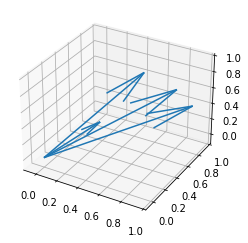

In [142]:
fig = plt.figure()
ax = plt.axes(projection = '3d')

ax.set_xlim([-0.1, 1])
ax.set_ylim([-0.1, 1])
ax.set_zlim([-0.1, 1])
ax.quiver(0, 0, 0, X_example[0][0], X_example[0][1], X_example[0][2])
ax.quiver(0, 0, 0, X_example[1][0], X_example[1][1], X_example[1][2])
ax.quiver(0, 0, 0, X_example[2][0], X_example[2][1], X_example[2][2])

ax.quiver(0, 0, 0, Y_example[0] / 5, Y_example[1] / 5, Y_example[2] / 5)

In [151]:
print(X_example)
print(Y_example)

print(np.dot(X_example.T, Y_example) / np.linalg.norm(X_example.T, 2, axis = 1))

[[0.6 0.6 0.9]
 [0.9 0.6 0.8]
 [0.3 0.4 0.3]]
[4.5 4.5 2. ]
[6.54790043 6.60922221 6.64803945]


In [128]:
# angles between X_i and Y
print(360 / (2 * 3.14) * np.arccos(np.dot(X_example.T, Y_example) / (np.linalg.norm(X_example.T, 2, axis = 1) * np.linalg.norm(Y_example, 2))))

[11.02221385  7.79700223  4.7401089 ]


In [315]:
print(w_example)

[0.18635436 0.46859588 0.83601596]


In [322]:
T = 10
p = 3

X = np.array([[1, 0, 0], [1, 1, 0], [1, 1, 1.]])

for i in range(p):
    X[:, i] = normalize(X[:, i])

print(X)
w = np.array([0.2, 0.5, 0.8])

Y = X @ w
# print(w)
print(Y)

print(OLS_full(X, Y))
print(OMP_full(X, Y))

[[0.57735027 0.         0.        ]
 [0.57735027 0.70710678 0.        ]
 [0.57735027 0.70710678 1.        ]]
[0.11547005 0.46902344 1.26902344]
(array([0.2, 0.5, 0.8]), [2, 1, 0])
(array([0.2, 0.5, 0.8]), [2, 0, 1])


In [327]:
# ### Initialize variables
# X = X_example
# Y = Y_example
w, F = np.zeros(p), []

### Get residual correlations
print(f"OMP:\nResidual Correlations: {np.round(OMP_GAINS(X, Y, w), 3)}.")

### Find largest one
F.append(np.argmax(OMP_GAINS(X, Y, w)))
print(f"Index Maximizing Residual Correlation: {np.argmax(OMP_GAINS(X, Y, w))}.")

### Create new vector w
print(f"Resulting vector w: {np.round(OLS(X, Y, F), 8)}.")

### Get residual correlations
print(f"\nStep 2:\nResidual Correlations: {np.round(OMP_GAINS(X, Y, OLS(X, Y, F)), 3)}.")

### Find largest one
print(f"Index Maximizing Residual Correlation: {np.argmax(OMP_GAINS(X, Y, OLS(X, Y, F)))}.")
F.append(np.argmax(OMP_GAINS(X, Y, OLS(X, Y, F))))

### Create new vector w
print(f"Resulting vector w: {np.round(OLS(X, Y, F), 2)}.")

### Get residual correlations
print(f"\nStep 3:\nResidual Correlations: {np.round(OMP_GAINS(X, Y, OLS(X, Y, F)), 3)}.")

### Find largest one
print(f"Index Maximizing Residual Correlation: {np.argmax(OMP_GAINS(X, Y, OLS(X, Y, F)))}.")
F.append(np.argmax(OMP_GAINS(X, Y, OLS(X, Y, F))))

### Create new vector w
print(f"Resulting vector w: {np.round(OLS(X, Y, F), 2)}.")

OMP:
Residual Correlations: [1.07  1.229 1.269].
Index Maximizing Residual Correlation: 2.
Resulting vector w: [0.         0.         1.26902344].

Step 2:
Residual Correlations: [0.337 0.332 0.   ].
Index Maximizing Residual Correlation: 0.
Resulting vector w: [0.51 0.   0.98].

Step 3:
Residual Correlations: [0.    0.125 0.   ].
Index Maximizing Residual Correlation: 1.
Resulting vector w: [0.2 0.5 0.8].


In [326]:
print(X)
print(Y - X @ np.array([0.0, 0.0, 1.26902344]))

print(np.dot(X[:, 1], Y - X @ np.array([0.0, 0.825, 0.0])))

[[0.57735027 0.         0.        ]
 [0.57735027 0.70710678 0.        ]
 [0.57735027 0.70710678 1.        ]]
[1.15470054e-01 4.69023444e-01 4.43119896e-09]
0.4039847411347833


In [273]:
print(0.01 * 360 / (2 * 3.14))

0.5732484076433121
